In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
# from os import listdir
# from os.path import isfile, join
# import time
import imutils
from tqdm import tqdm #, trange
import math
from math import ceil
# import glob
# from pathlib import Path
# import shutil
from copy import deepcopy

In [16]:
filename = 'C:/ML_YGO/Data/full_db.txt'
with open(filename) as file:
    full_db = [line.rstrip() for line in file]

full_db_digit = []
full_db_name_ko = []

for item in full_db:
    data = item.split("\t")
    try:
        full_db_digit.append(data[1])
    except:
        full_db_digit.append(None)
    try:
        full_db_name_ko.append(data[3])
    except:
        full_db_name_ko.append(None)

1208-001.jpg


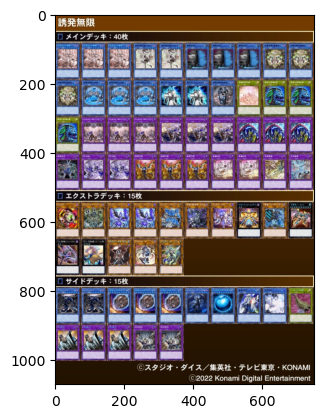

In [17]:
# Set fixed width
sample = "증식의 G"
w1 = 1000
threshold = 0.75
deck_index = 0

######################

dup_tol = 10
sort_round = 10

# Choose Deck
deck_dir = 'C:/ML_YGO/Deck/'
deck_pool = os.listdir(deck_dir)

deck_ind = []
for deck in deck_pool:
    deck_txt = deck.split(".")[0]
    deck_txt = deck_txt.split("(")[0]
    deck_number = int(deck_txt.replace("-","0"))
    deck_ind.append(deck_number)

deck_sorted = [x for _,x in sorted(zip(deck_ind,deck_pool))]
deck = deck_sorted[deck_index]

print(deck)

preview = cv2.imread(f'{deck_dir}{deck}')
plt.imshow(preview, cmap='gray')

In [14]:
def dist(p1,p2):
    p1X = p1[0]
    p1Y = p1[1]
    p2X = p2[0]
    p2Y = p2[1]

    dX = (p2X - p1X) **2
    dY = (p2Y - p1Y) **2
    
    return dX+dY

# creates sorting mask funciton to sort points
def sort_pt(pts):
    sort_up = 1000
    ind_pt = []
    new_pt = []
    for i in range(len(pts)):
        ind_pt.append(i) # 0 1 2...
        nx = sort_round * math.ceil(pts[i][0]/sort_round)
        ny = sort_round * math.ceil(pts[i][1]/sort_round)
        new = nx + ny * sort_up
        new_pt.append(new)
    return [x for _, x in sorted(zip(new_pt, ind_pt))]

# Read from txt for limited pool
path_pool = 'C:/ML_YGO/YGO_DB/'
filename = 'C:/ML_YGO/Data/used_db.txt'

with open(filename) as file:
    used_db = [line.rstrip() for line in file]
used_dbs = [f"{str(code)}.jpg" for code in used_db]
pool = used_dbs
print(len(pool))

# Set Testing
sample_index = full_db_name_ko.index(sample)
sample_digit = full_db_digit[sample_index]

#### Run the Test
img_rgb = cv2.imread(f'{deck_dir}{deck}')  #Large image

print(f'{deck_dir}{deck}')

img_rgb = imutils.resize(img_rgb, width = w1)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

template = cv2.imread(f'{path_pool}{sample_digit}.jpg', 0)  #Small image (template)

width = img_rgb.shape[1]
height = img_rgb.shape[0]

#########################################################
best_match = None

sc1 = int((w1 / 10) * 0.8 )
sc2 = int((w1 / 10) * 1.1 )
sc_dif = abs(sc2-sc1)+1

for scale in np.linspace(sc1, sc2, sc_dif):  #Pick scale based on your estimate of template to object in the image ratio
    resized_template = imutils.resize(template, width = int(scale))    
    res = cv2.matchTemplate(img_gray, resized_template, cv2.TM_SQDIFF)
    min_val, _, min_loc, _ = cv2.minMaxLoc(res)  #Only care about minimum value and location as we are using TM_SQDIFF

    if best_match is None or min_val <= best_match[0]:
        ideal_scale=scale  #Save the ideal scale for printout. 
        h, w = resized_template.shape[::] #Get the size of the scaled template to draw the rectangle. 
        best_match = [min_val, min_loc, ideal_scale]

ideal_w = int(template.shape[1]*ideal_scale / template.shape[0])
ideal_h = int(ideal_scale)
print(f"Ideal template image size is : {ideal_w} x {ideal_h}" )
w2 = int(ideal_scale)

#########################################################

card_loc = []
card_pos = []

#######################################################
for card in tqdm(pool):
    template = cv2.imread(f'{path_pool}{card}', 0) #small image

    # print(f'{path_pool}{card}')

    template = imutils.resize(template, width = w2)
    h, w = template.shape[::]
    res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)
    loc=np.where(res >= threshold)

    num_loc = []
    for pt in zip(*loc[::-1]):
        num_loc.append(pt)
        cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (255, 255, 255), 1)
    card_loc.append(num_loc)

    # get possibility
    gamma = []
    for i in range(len(loc[0])):
        u = loc[0][i]
        v = loc[1][i]
        temp = res[u][v]
        gamma.append(temp)
    card_pos.append(gamma)
#######################################################
zip_name = []
zip_pt = []
zip_pos = []
for i in range(len(pool)):
    digit = pool[i].split(".")[0]
    for j in range(len(card_loc[i])):
        coord = card_loc[i][j]
        coX = coord[0]
        coY = coord[1]
        zip_pt.append([coX, coY])

        pos = card_pos[i][j]
        zip_pos.append(pos)

        ind = full_db_digit.index(digit)
        name = full_db_name_ko[ind]
        zip_name.append(name)
#######################################################
dup_pt = deepcopy(zip_pt)
i=0
while i< len(dup_pt):
    j = len(dup_pt) -1
    while j > i:
        d = dist( dup_pt[i], dup_pt[j])
        if d < dup_tol **2 :
            dup_pt.pop(j)
        j = j- 1
    i += 1
#######################################################
group_pt = []
group_pos = []
group_name = []
for item_ in dup_pt:
    pt_group = []
    pos_group = []
    name_group = []
    for j in range(len(zip_pt)):
        d = dist(item_, zip_pt[j])
        if d < dup_tol**2:
            pt_group.append(zip_pt[j])
            pos_group.append(zip_pos[j])
            name_group.append(zip_name[j])
    group_pt.append(pt_group)
    group_pos.append(pos_group)
    group_name.append(name_group)
#######################################################
pos_name=[]
pos_pt = []
for i in range(len(group_pos)):
    name = [x for _ , x in sorted(zip(group_pos[i],group_name[i]), reverse=True)]
    pt = [x for _ , x in sorted(zip(group_pos[i],group_pt[i]), reverse=True)]
    pos_name.append(name[0])
    pos_pt.append(pt[0])
#######################################################
sort_mask = sort_pt(pos_pt)
sort_name = []
for i in sort_mask:
    name = pos_name[i]
    sort_name.append(name)
#######################################################
deck_list = deepcopy(sort_name) #clean_name ->
deck_len = len(deck_list)
main_len = deck_len - 30
if main_len <60:
    deck_list.insert(main_len,"메인덱")
start = -30
while len(deck_list)< 90:
    deck_list.insert(start, "")
    start = start-1
deck_short = deck.split(".")[0]
deck_list.insert(0, deck_short )

#######################################################

dir_write = 'C:/ML_YGO/Output/cleaned_deck_list.txt'

with open(dir_write, 'w', encoding="utf-8") as fp:
    for item in deck_list:
        fp.write("%s\t" % item)

os.startfile(dir_write)

print("Done")

824
C:/ML_YGO/Deck/1208-001.jpg
Ideal template image size is : 67 x 98


100%|██████████| 824/824 [00:32<00:00, 25.09it/s]


Done
